In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import pickle
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('/content/drive/MyDrive/Dissertation/xgboost_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

with open('/content/drive/MyDrive/Dissertation/xgboost_label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open('/content/drive/MyDrive/Dissertation/xgboost_feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open('/content/drive/MyDrive/Dissertation/xgboost_model_results.json', 'r') as f:
    model_results = json.load(f)

print("Model loaded successfully!")

print(f"Test Accuracy: {model_results['test_accuracy']:.3f}")
print('Number of features: ', len(feature_names))

Model loaded successfully!
Test Accuracy: 0.905
Number of features:  38


In [3]:
class_names = label_encoder.classes_
print('\nDiabetes types in dataset: ', len(class_names))
print(class_names)


Diabetes types in dataset:  13
['cystic fibrosis-related diabetes (cfrd)' 'gestational diabetes' 'lada'
 'mody' 'neonatal diabetes mellitus (ndm)' 'prediabetic'
 'secondary diabetes' 'steroid-induced diabetes' 'type 1 diabetes'
 'type 2 diabetes' 'type 3c diabetes (pancreatogenic diabetes)'
 'wolcott-rallison syndrome' 'wolfram syndrome']


In [4]:
df_clean = pd.read_csv('/content/drive/MyDrive/Dissertation/clean_diabetes_data.csv')

X = df_clean[feature_names].copy()
y = df_clean['diabetes_type']
y_encoded = label_encoder.transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print('Training set: ', len(X_train), 'samples')
print('Validation set: ', len(X_val), 'samples')
print('Test set: ', len(X_test), 'samples')

Training set:  42000 samples
Validation set:  14000 samples
Test set:  14000 samples


In [5]:
n_samples, n_features = X.shape
n_classes = len(class_names)

print(f"Samples per class: {n_samples/n_classes:.0f}")
print(f"Recommended minimum: {n_features*n_classes*10:,}")
print("Adequate data" if n_samples >= n_features*n_classes*10 else "Insufficient data")

shap_n = 1000
print("\nSHAP Sample Size")
print(f"Samples used: {shap_n} ({shap_n/n_samples:.1%} of data)")
print(f"≈ {shap_n/n_classes:.0f} per class")


Samples per class: 5385
Recommended minimum: 4,940
Adequate data

SHAP Sample Size
Samples used: 1000 (1.4% of data)
≈ 77 per class


In [6]:
explainer = shap.TreeExplainer(xgb_model)

sample_size = min(1000, len(X_test))
X_shap_sample = X_test.iloc[:sample_size].copy()
y_shap_sample = y_test[:sample_size]

shap_values = explainer.shap_values(X_shap_sample)
expected_value = explainer.expected_value

print('SHAP values shape: ', shap_values.shape)

SHAP values shape:  (1000, 38, 13)


In [7]:
mean_shap_values = np.abs(shap_values).mean(axis=(0, 2))

working_feature_names = feature_names

In [8]:
global_importance_df = pd.DataFrame({
    'feature': working_feature_names,
    'mean_abs_shap': mean_shap_values
}).sort_values('mean_abs_shap', ascending=False)

print("Top 15 Most Important Features (SHAP Analysis):")
print(global_importance_df.head(15).to_string(index=False))

print("\nTotal features analyzed: ", len(global_importance_df))

Top 15 Most Important Features (SHAP Analysis):
                      feature  mean_abs_shap
         Blood Glucose Levels       0.894445
                          Age       0.869803
 Weight Gain During Pregnancy       0.725506
               Blood Pressure       0.536945
           Cholesterol Levels       0.394024
                          BMI       0.355520
          Waist Circumference       0.338723
               Insulin Levels       0.294794
                 Birth Weight       0.273835
      Digestive Enzyme Levels       0.229826
           Pulmonary Function       0.163397
            Pancreatic Health       0.090600
     Neurological Assessments       0.060963
Cystic Fibrosis Diagnosis_yes       0.002592
   Urine Test_protein present       0.002175

Total features analyzed:  38


<Figure size 1200x1000 with 0 Axes>

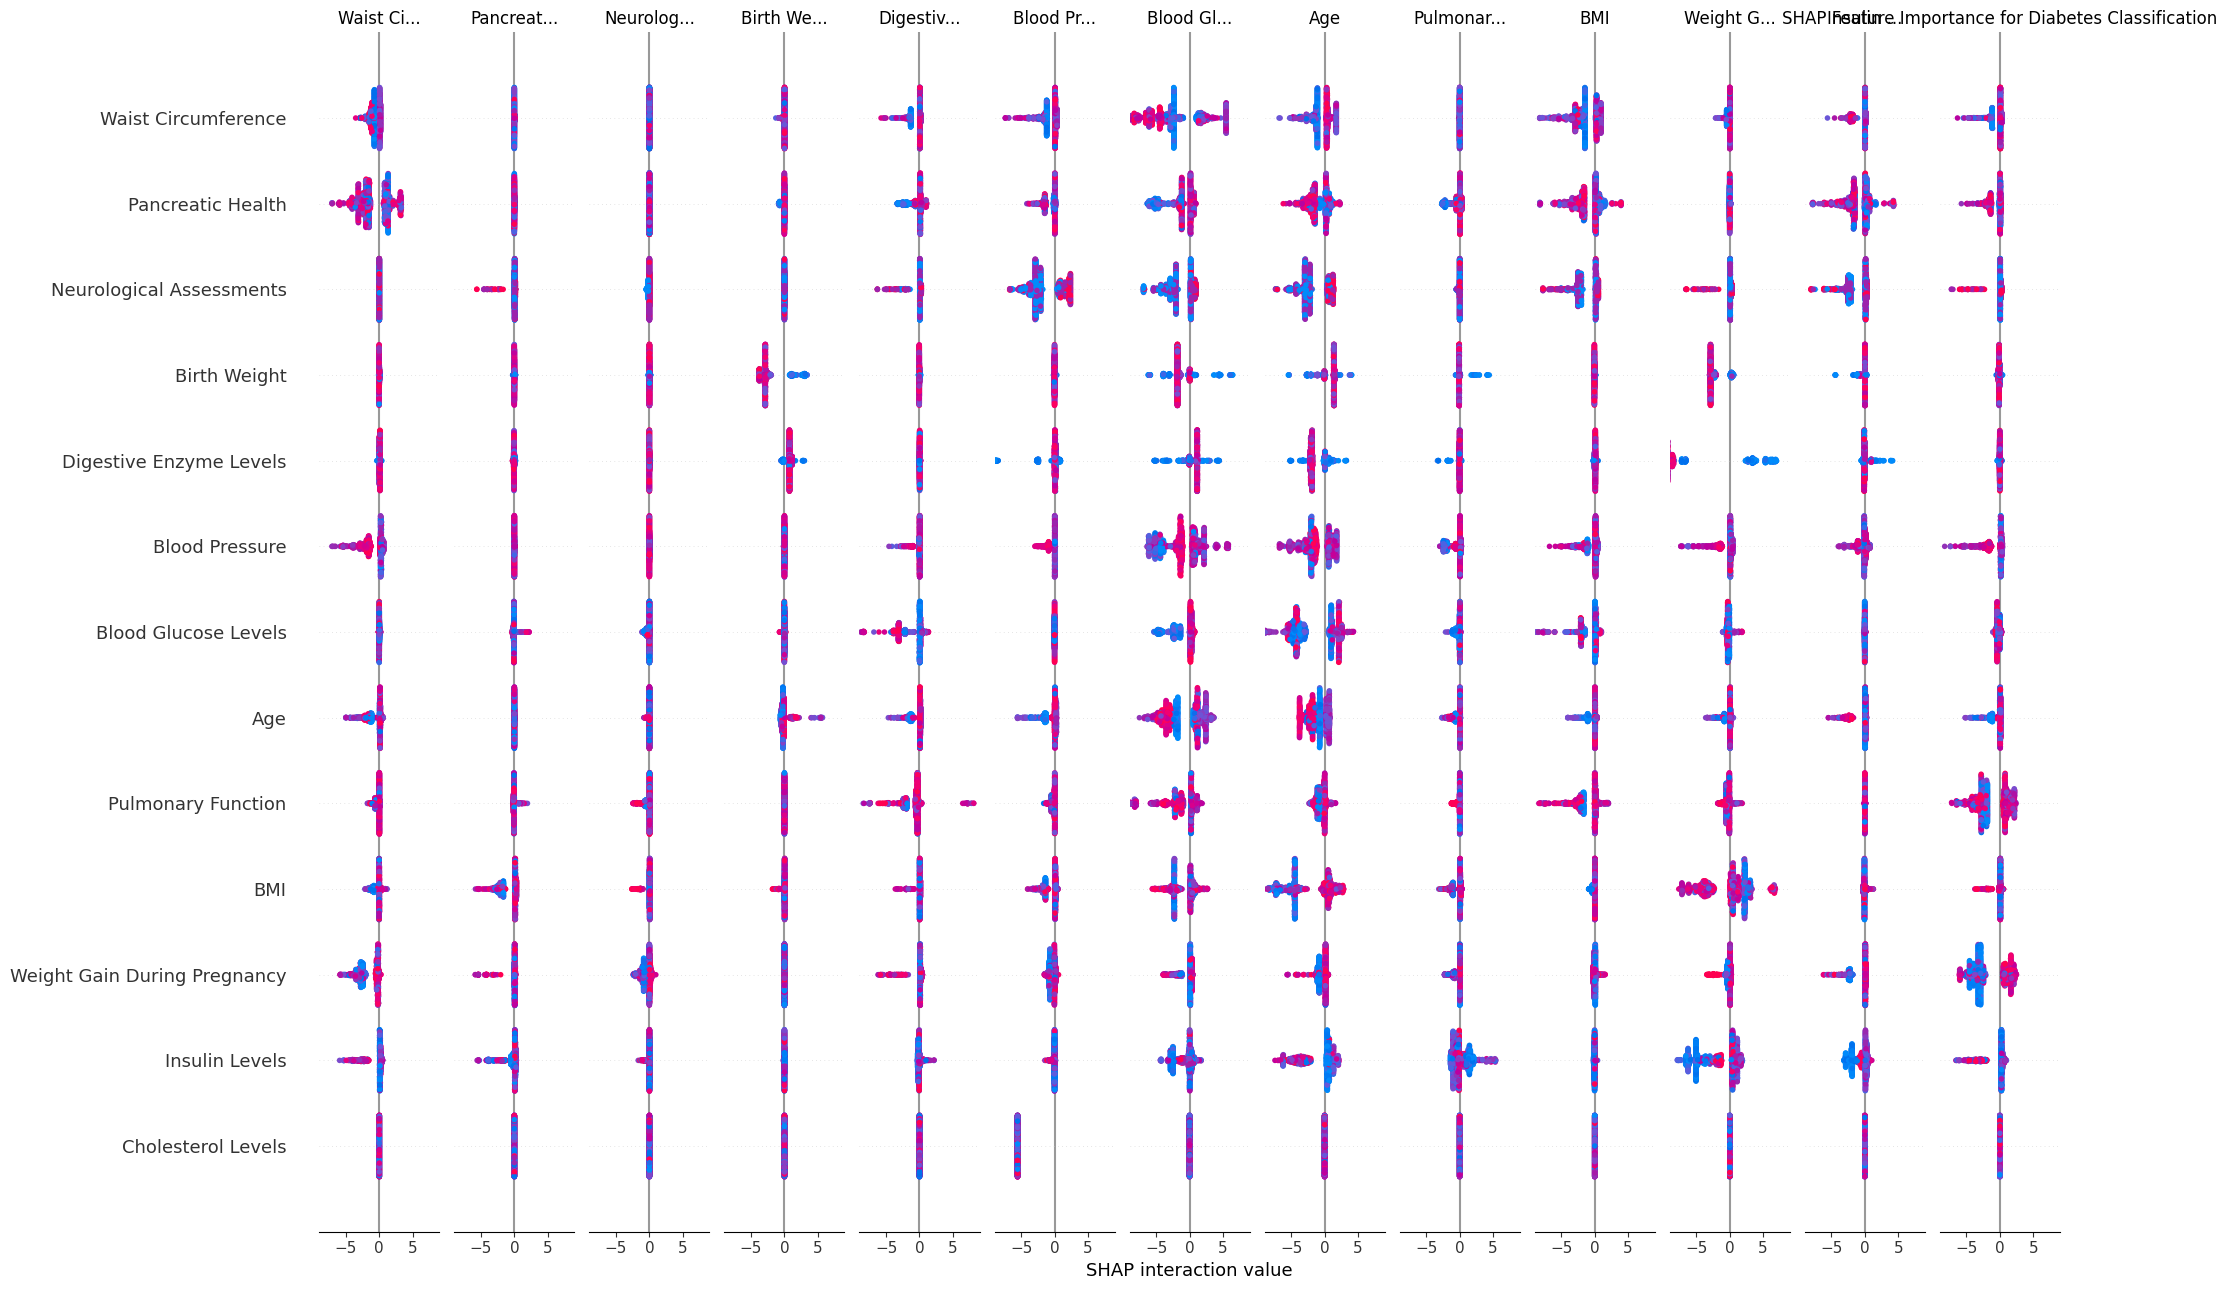

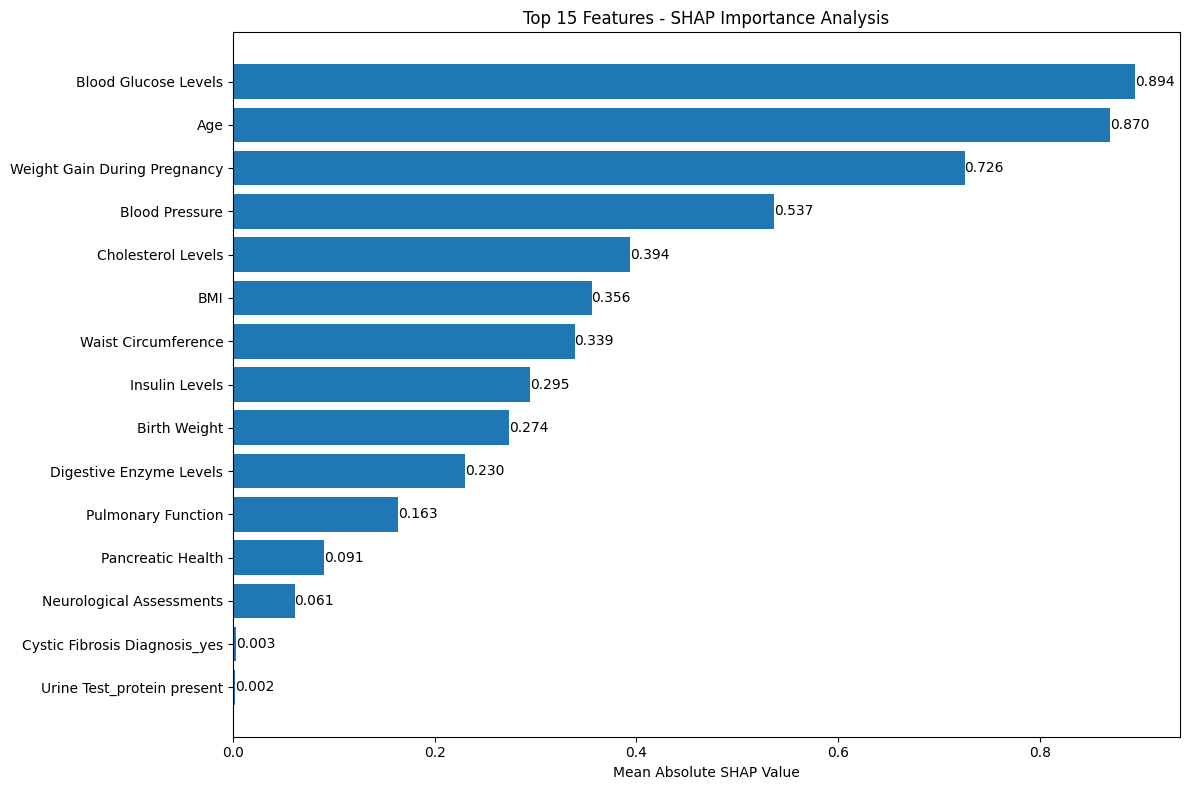

In [9]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap_sample, feature_names=working_feature_names, show=False, max_display=15)
plt.title('SHAP Feature Importance for Diabetes Classification')
plt.tight_layout()
plt.show()

top_features = global_importance_df.head(15)
plt.figure(figsize=(12, 8))
plt.barh(top_features['feature'], top_features['mean_abs_shap'])
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 15 Features - SHAP Importance Analysis')
plt.gca().invert_yaxis()

for i, v in enumerate(top_features['mean_abs_shap']):
    plt.text(v, i, f'{v:.3f}', va='center', ha='left')

plt.tight_layout()
plt.show()

In [10]:
class_importance = {}

for i, name in enumerate(class_names):
    shap_mean = np.abs(shap_values[:, :, i]).mean(axis=0)

    class_importance[name] = pd.DataFrame({
        'feature': working_feature_names,
        'mean_abs_shap': shap_mean
    }).sort_values('mean_abs_shap', ascending=False)

selected_classes = ['type 1 diabetes', 'type 2 diabetes', 'type 3c diabetes (pancreatogenic diabetes)', 'steroid-induced diabetes', 'wolcott-rallison syndrome', 'wolfram syndrome', 'gestational diabetes', 'mody', 'cystic fibrosis-related diabetes (cfrd)', 'lada', 'neonatal diabetes mellitus (ndm)', 'prediabetic', 'secondary diabetes']

for name in selected_classes:
    if name in class_importance:
        print("\n" + name + ":")
        top5 = class_importance[name].head(5)
        for j, row in top5.iterrows():
            print(f"  {j+1}. {row['feature']} - {row['mean_abs_shap']:.4f}")


type 1 diabetes:
  6. Waist Circumference - 1.0207
  7. Blood Glucose Levels - 0.8377
  3. BMI - 0.8019
  1. Insulin Levels - 0.7589
  2. Age - 0.7025

type 2 diabetes:
  5. Cholesterol Levels - 1.1502
  7. Blood Glucose Levels - 0.9610
  3. BMI - 0.7275
  12. Digestive Enzyme Levels - 0.6197
  2. Age - 0.2958

type 3c diabetes (pancreatogenic diabetes):
  4. Blood Pressure - 1.2160
  2. Age - 1.1199
  7. Blood Glucose Levels - 0.8450
  3. BMI - 0.8160
  1. Insulin Levels - 0.7479

steroid-induced diabetes:
  5. Cholesterol Levels - 1.3043
  6. Waist Circumference - 0.8924
  1. Insulin Levels - 0.4204
  7. Blood Glucose Levels - 0.4187
  8. Weight Gain During Pregnancy - 0.3463

wolcott-rallison syndrome:
  8. Weight Gain During Pregnancy - 4.2337
  2. Age - 0.8214
  7. Blood Glucose Levels - 0.5597
  13. Birth Weight - 0.3520
  4. Blood Pressure - 0.2588

wolfram syndrome:
  13. Birth Weight - 2.7909
  8. Weight Gain During Pregnancy - 1.1849
  7. Blood Glucose Levels - 0.9184
  2. A

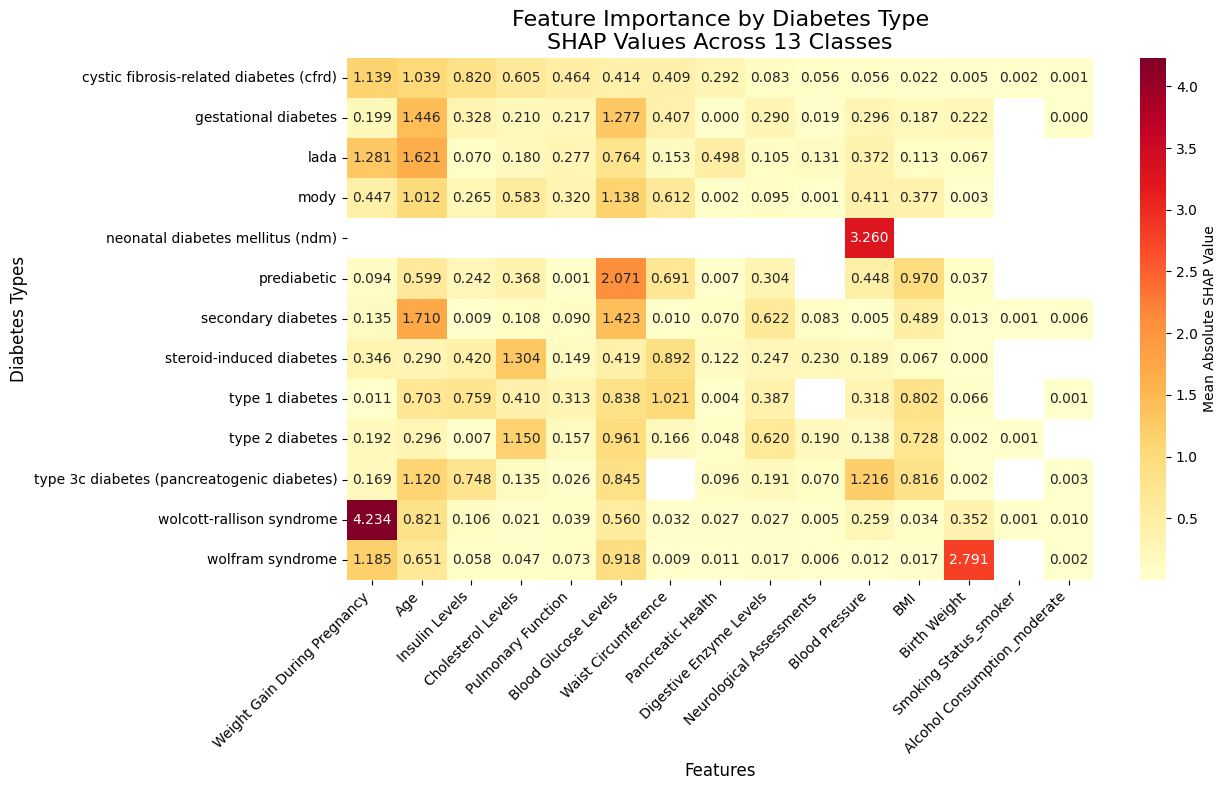

In [11]:
top_n_features = 15

all_top_features = pd.concat([
    class_importance[class_name].nlargest(top_n_features, 'mean_abs_shap')['feature']
    for class_name in class_names
]).unique()[:top_n_features]

importance_matrix = pd.DataFrame(
    0, index=class_names, columns=all_top_features
)

for class_name in class_names:
    class_features = class_importance[class_name].set_index('feature')['mean_abs_shap']
    importance_matrix.loc[class_name, class_features.index.intersection(all_top_features)] = \
        class_features[all_top_features].fillna(0)

plt.figure(figsize=(13, 8))
sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            mask=importance_matrix==0, cbar_kws={'label': 'Mean Absolute SHAP Value'})
plt.title('Feature Importance by Diabetes Type\nSHAP Values Across 13 Classes', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Diabetes Types', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [15]:
sample_indices = [0, 100, 200]

for idx in sample_indices:
    sample_pred = xgb_model.predict(X_shap_sample.iloc[[idx]])[0]
    sample_proba = xgb_model.predict_proba(X_shap_sample.iloc[[idx]])[0]
    true_label = y_shap_sample[idx]

    predicted_class = class_names[sample_pred]
    true_class = class_names[true_label]
    confidence = sample_proba[sample_pred]

    print(f"\nSample {idx}:")
    print('True Class: ', true_class)
    print('Predicted: ', predicted_class)
    print(f"  Confidence: {confidence:.3f}")
    print(f"  Correct: {'Yes' if sample_pred == true_label else 'No'}")

    sample_shap_values = shap_values[idx, :, sample_pred]

    feature_contributions = pd.DataFrame({
        'feature': working_feature_names,
        'shap_value': sample_shap_values
    })

    feature_contributions['abs_shap'] = np.abs(feature_contributions['shap_value'])
    top_features = feature_contributions.sort_values('abs_shap', ascending=False).head(3)

    print('Top 3 Contributing Features:')
    for j, (_, row) in enumerate(top_features.iterrows(), 1):
        direction = "increases" if row['shap_value'] > 0 else "decreases"
        print(f"    {j}. {row['feature']:<25}: {row['shap_value']:+.4f} ({direction} prediction)")


Sample 0:
True Class:  type 1 diabetes
Predicted:  type 1 diabetes
  Confidence: 0.999
  Correct: Yes
Top 3 Contributing Features:
    1. Waist Circumference      : +1.5550 (increases prediction)
    2. Age                      : +1.1090 (increases prediction)
    3. Digestive Enzyme Levels  : +0.4917 (increases prediction)

Sample 100:
True Class:  gestational diabetes
Predicted:  gestational diabetes
  Confidence: 0.950
  Correct: Yes
Top 3 Contributing Features:
    1. Blood Glucose Levels     : +1.2215 (increases prediction)
    2. Age                      : +0.7077 (increases prediction)
    3. Birth Weight             : -0.1848 (decreases prediction)

Sample 200:
True Class:  neonatal diabetes mellitus (ndm)
Predicted:  neonatal diabetes mellitus (ndm)
  Confidence: 1.000
  Correct: Yes
Top 3 Contributing Features:
    1. Blood Pressure           : +8.9912 (increases prediction)
    2. Insulin Levels           : +0.0000 (decreases prediction)
    3. Age                      : +0

In [16]:
shap_results = {
    'analysis_info': {
        'samples_analyzed': len(X_shap_sample),
        'features': len(working_feature_names),
        'classes': len(class_names),
        'model_accuracy': model_results['test_accuracy']
    },
    'global_importance': global_importance_df.head(15).to_dict('records'),
    'class_specific': {
        class_name: importance_df.head(5).to_dict('records')
        for class_name, importance_df in class_importance.items()
    },
    'top_features': global_importance_df.head(10)['feature'].tolist()
}

np.save('shap_values.npy', shap_values)
X_shap_sample.to_csv('shap_samples.csv', index=False)

with open('shap_results.json', 'w') as f:
    json.dump(shap_results, f, indent=2)

print("SHAP results saved successfully!")

SHAP results saved successfully!
